# Title: Carbon Emissions Observations
By: Laura Suchomska, Ravi Malde, Augustin Goudet

# I. Package Install Installation

In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
import warnings
warnings.filterwarnings("ignore")

# II. Data Collection - CIA WorldFactbook

In [2]:
#Collating all the potential sources of data from the CIA WorldFactbook

files = ['AIRPORTS',
'AREA',
'BUDGET',
'continent',
'CURACCT',
'DEBTFOREIGNERS',
'EDUCATIONSPEND',
'electricconsupmtion',
'emissions',
'EXPORTS',
'fossilelectricity',
'GDP',
'GDPGROWTH',
'GDPPERCAP',
'hydroelectricity',
'IMPORTS',
'INDUSTPRODGR',
'internetusers',
'LIFEXP',
'MARMERCHANT',
'MIGRATION',
'MILIEXPENDITURE',
'naturalgasconsumption',
'nuclearelectricity',
'otherrenewableelectricity',
'petroleumconsumption',
'POPGROWTH',
'POPULATION',
'PUBLICDEBT',
'RAILWAYS',
'ROADWAYS',
'UNEMPLOYMENT',
'WATERWAYS',
'WORKFORCE']

In [3]:
#storing all the csv in a dictionary

pd_dict = {}
for file in files:
    pd_dict[file] = pd.read_csv('{}.csv'.format(file))

In [4]:
#Creating the dataframes from the dictionary

base_df = pd_dict['continent']
area_df = pd_dict['AREA']
petrol_df = pd_dict['petroleumconsumption']
users_df = pd_dict['internetusers']
hydro_df = pd_dict['hydroelectricity']
nuclear_df = pd_dict['nuclearelectricity']
otherrenew_df = pd_dict['otherrenewableelectricity']
mili_df = pd_dict['MILIEXPENDITURE']
co2_df = pd_dict['emissions']
pop_df = pd_dict['POPULATION']

# III. Data Transformation 

In [5]:
#Standardization of country names to merge
for i, row in base_df.iterrows():
    row['country_name'] = row['country_name'].split(",")
    row ['country_name'] = row['country_name'][0]

In [6]:
#Renaming columns to facilitate merge
mili_df.rename(columns = {"% OF GDP": "mili_exp_gdp"}, inplace = True)
base_df.rename(columns = {'country_name':'Country'}, inplace = True)


In [7]:
#Merging base dataframe to bring in continent_name and country fields together
base_df.merge(area_df, on = 'Country', how = 'left')
base_df.head(n=1)

,continent_name,Country
0,Asia,Afghanistan


In [8]:
#Merging relevant country attributes to create a single dataframe to work on

df1 = base_df.merge(area_df, on = 'Country', how = 'left')
df1.rename(columns = {'Country':'country'}, inplace = True)
df2 = df1.merge(petrol_df, on = 'country', how = 'outer')
df3 = df2.merge(users_df, on = 'country', how = 'outer')
df4 = df3.merge(hydro_df, on = 'country', how = 'outer')
df5 = df4.merge(nuclear_df, on = 'country', how = 'outer')
df6 = df5.merge(otherrenew_df, on = 'country', how = 'outer')
mili_df.rename(columns = {'COUNTRY':'country'}, inplace = True)
df7 = df6.merge(mili_df, on = 'country', how = 'outer')
df8 = df7.merge(co2_df, on = 'country', how = 'outer')
pop_df.rename(columns = {'Country':'country'}, inplace = True)
df9 = df8.merge(pop_df, on = 'country', how = 'outer')
df9.head(n=2)


,continent_name,country,Index_x,Area_sqKm,Unnamed: 0_x,refined_petroleum_consumption_barrels_per_day,year_x,Unnamed: 4_x,Unnamed: 0_y,number_of_internet_users,...,Unnamed: 4_x,Unnamed: 0,year,carbon_emissions_from_energy_consumption_MT,Unnamed: 4_y,Index_y,Population,Month,Year,Unnamed: 5
0,Asia,Afghanistan,42.0,"652,230.00",117.0,"35,000",2016.0,est.,NaN,NaN,...,NaN,111.0,2017.0,"9,067,000.00",est.,39.0,"36,643,815",July,2020,est.
1,Europe,Albania,145.0,"28,748.00",120.0,"29,000",2016.0,est.,111.0,"2,016,516",...,est.,136.0,2017.0,"4,500,000.00",est.,136.0,"3,074,579",July,2020,est.


In [9]:
#Creating our main DataFrame with relevant country attributes

final_df = df9[['continent_name','country','Area_sqKm','refined_petroleum_consumption_barrels_per_day','number_of_internet_users', 'hydro_percentage_of_electricity_production','nuclear_percentage_of_electricity_production', 'other_renewable_percentage_of_electricity_production',"mili_exp_gdp","carbon_emissions_from_energy_consumption_MT","Population"]].copy()
final_df.sample(n=2)

,continent_name,country,Area_sqKm,refined_petroleum_consumption_barrels_per_day,number_of_internet_users,hydro_percentage_of_electricity_production,nuclear_percentage_of_electricity_production,other_renewable_percentage_of_electricity_production,mili_exp_gdp,carbon_emissions_from_energy_consumption_MT,Population
217,Africa,Swaziland,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32,Europe,Bulgaria,"110,879.00","97,000","4,274,328",23.0,20.0,19.0,3.25,"46,310,000.00","6,966,899"


In [10]:
#Checking for data point format / change objects to floats for numerical variables
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 283 entries, 0 to 282
Data columns (total 11 columns):
continent_name                                          257 non-null object
country                                                 283 non-null object
Area_sqKm                                               222 non-null object
refined_petroleum_consumption_barrels_per_day           221 non-null object
number_of_internet_users                                232 non-null object
hydro_percentage_of_electricity_production              221 non-null float64
nuclear_percentage_of_electricity_production            221 non-null float64
other_renewable_percentage_of_electricity_production    220 non-null float64
mili_exp_gdp                                            164 non-null float64
carbon_emissions_from_energy_consumption_MT             220 non-null object
Population                                              244 non-null object
dtypes: float64(4), object(7)
memory usage: 26.5+ KB


In [11]:
# Removing commas from numbers to transform objects into floats

final_df['Area_sqKm'] = final_df['Area_sqKm'].str.replace(',', '')
final_df['refined_petroleum_consumption_barrels_per_day'] = final_df['refined_petroleum_consumption_barrels_per_day'].str.replace(',', '')
final_df['number_of_internet_users'] = final_df['number_of_internet_users'].str.replace(',', '')
final_df['carbon_emissions_from_energy_consumption_MT'] = final_df['carbon_emissions_from_energy_consumption_MT'].str.replace(',', '')
final_df['Population'] = final_df['Population'].str.replace(',', '')



In [12]:
#Conversion of objects to floats

final_df['Area_sqKm'] = final_df['Area_sqKm'].astype(float)
final_df['refined_petroleum_consumption_barrels_per_day'] = final_df['refined_petroleum_consumption_barrels_per_day'].astype(float)
final_df['number_of_internet_users'] = final_df['number_of_internet_users'].astype(float)
final_df['carbon_emissions_from_energy_consumption_MT'] = final_df['carbon_emissions_from_energy_consumption_MT'].astype(float)
final_df['Population'] = final_df['Population'].astype(float)


# IV. Null Values Treatment

In [13]:
#Checking for null values

final_df.isnull().sum()

continent_name                                           26
country                                                   0
Area_sqKm                                                61
refined_petroleum_consumption_barrels_per_day            62
number_of_internet_users                                 51
hydro_percentage_of_electricity_production               62
nuclear_percentage_of_electricity_production             62
other_renewable_percentage_of_electricity_production     63
mili_exp_gdp                                            119
carbon_emissions_from_energy_consumption_MT              63
Population                                               39
dtype: int64

In [14]:
#Treatment for null values - dropping erroneous names / Nan Area points
final_df.dropna(subset=['continent_name', "Area_sqKm", "refined_petroleum_consumption_barrels_per_day"], inplace = True)


In [15]:
#Treatment for null values - adding mili expenditures median for two countries / fill with 0 for remainder

median_exp = final_df['mili_exp_gdp'].median()
armed_countries = ['Syria','Qatar']

rows_to_change = list(final_df[(final_df['mili_exp_gdp'].isnull()) &
         (final_df.country.isin(armed_countries))].index)

final_df.loc[rows_to_change,'mili_exp_gdp'] = median_exp
final_df[final_df.country.isin(armed_countries)]

final_df['mili_exp_gdp'].fillna(0,inplace = True )

In [16]:
##Treatment for null values - adding internet users median for two countries / fill with 0 for remainder

median_int = final_df['number_of_internet_users'].median()
internet_users = ['Afghanistan','South Sudan']

int_rows_to_change = list(final_df[(final_df['number_of_internet_users'].isnull()) &
         (final_df.country.isin(internet_users))].index)

final_df.loc[int_rows_to_change,'number_of_internet_users'] = median_int
final_df[final_df.country.isin(internet_users)]

final_df['number_of_internet_users'].fillna(0,inplace = True )

final_df.isnull().sum()

continent_name                                          0
country                                                 0
Area_sqKm                                               0
refined_petroleum_consumption_barrels_per_day           0
number_of_internet_users                                0
hydro_percentage_of_electricity_production              0
nuclear_percentage_of_electricity_production            0
other_renewable_percentage_of_electricity_production    0
mili_exp_gdp                                            0
carbon_emissions_from_energy_consumption_MT             0
Population                                              0
dtype: int64

# VI. Exploratory Data Analysis

In [17]:
#Crombining non-fossil electricity fields / proxy for renewable source

final_df['non_fossil_electricity'] = final_df['hydro_percentage_of_electricity_production'] + final_df['nuclear_percentage_of_electricity_production'] + final_df['other_renewable_percentage_of_electricity_production']


In [18]:
#Creating a continent view to get mean values per continent

continent_df = final_df.pivot_table(index = 'continent_name', values = ['refined_petroleum_consumption_barrels_per_day', 
                                                         'number_of_internet_users','non_fossil_electricity' 
                                                         ,'carbon_emissions_from_energy_consumption_MT',"mili_exp_gdp", 'Population'], aggfunc = np.mean)



continent_df.reset_index(inplace = True)

#Styling DataFrame using styler

continent_df['mili_exp_gdp'] = continent_df['mili_exp_gdp'].div(100).round(4)
continent_df['non_fossil_electricity'] = continent_df['non_fossil_electricity'].div(100).round(4)


cdf = continent_df.style.format({'continent_name': str.upper,
                           'carbon_emissions_from_energy_consumption_MT': '{:20,.0f}',"mili_exp_gdp":'{:.2%}',
                          "number_of_internet_users":'{:20,.0f}', "refined_petroleum_consumption_barrels_per_day":'{:20,.0f}',"non_fossil_electricity":'{:.2%}'})

cdf

,continent_name,Population,carbon_emissions_from_energy_consumption_MT,mili_exp_gdp,non_fossil_electricity,number_of_internet_users,refined_petroleum_consumption_barrels_per_day
0,AFRICA,2.49318e+07,"27,374,741",1.43%,37.33%,"5,868,278","77,448"
1,ASIA,9.7616e+07,"466,522,251",2.50%,27.96%,"39,905,819","873,358"
2,EUROPE,1.84373e+07,"145,304,857",1.55%,49.60%,"13,921,629","415,173"
3,NORTH AMERICA,1.8987e+07,"211,292,993",0.52%,24.23%,"12,467,495","820,406"
4,OCEANIA,2.40559e+06,"29,204,432",0.25%,27.59%,"1,538,164","85,270"
5,SOUTH AMERICA,3.54592e+07,"96,821,667",1.49%,51.42%,"20,381,686","485,792"


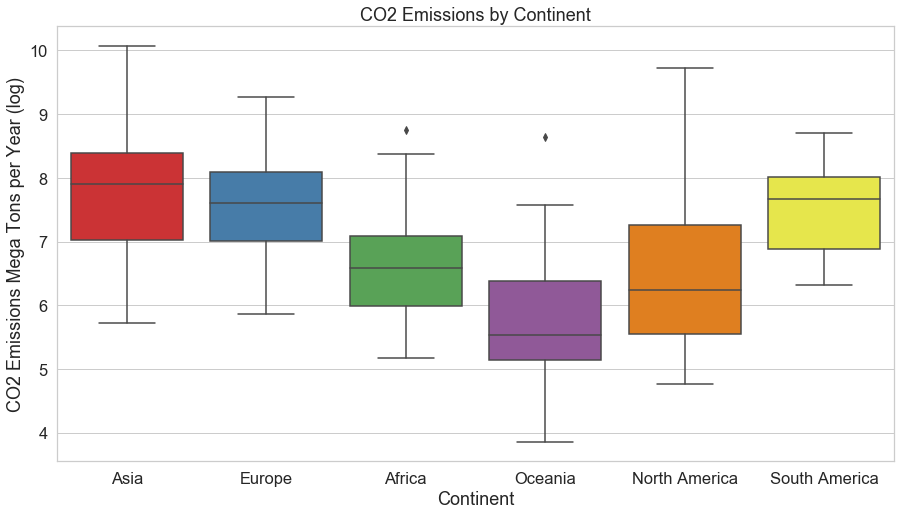

In [56]:
plt.figure(figsize=(15,8))
sns.set(font_scale=1.5)
sns.set_palette("Set1")
sns.set_style("whitegrid")
sns.boxplot(x='continent_name',y='co2_log',data=final_df)
plt.xlabel("Continent")
plt.ylabel("CO2 Emissions Mega Tons per Year (log)")
plt.title("CO2 Emissions by Continent")
# sns.lineplot(x='continent_name',y=final_df['co2_log'].mean(),data=final_df, color='orange')
plt.show()

# VII. Evaluating Residual Distribution

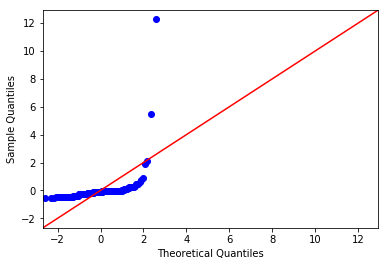

In [19]:
#CO2 emissions residuals - not displaying normality

co2_model = ols("carbon_emissions_from_energy_consumption_MT ~ C(continent_name)", data=final_df).fit()
residuals = co2_model.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig.show()

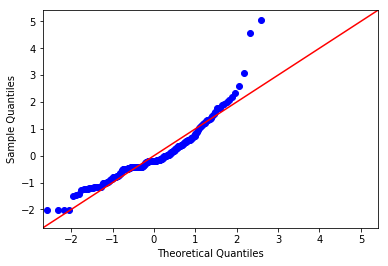

In [20]:
#Military expenditures residuals - displaying some normality

mili_model = ols("mili_exp_gdp ~ C(continent_name)", data=final_df).fit()
residuals = mili_model.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig.show()

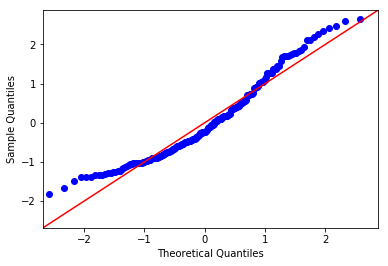

In [21]:
#Non-fossil energy prod residuals - displaying normality

ele_model = ols("non_fossil_electricity ~ C(continent_name)", data=final_df).fit()
residuals = ele_model.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig.show()

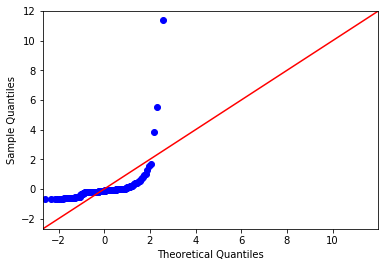

In [22]:
#number of internet users residuals - not displaying normality


int_model = ols("number_of_internet_users ~ C(continent_name)", data=final_df).fit()
residuals = int_model.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig.show()

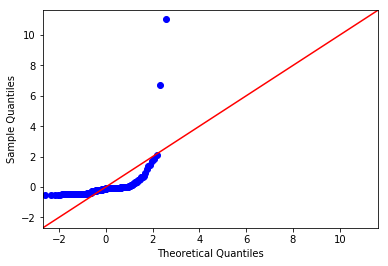

In [23]:
#petrol consumption residuals - not displaying normality

petrol_model = ols("refined_petroleum_consumption_barrels_per_day ~ C(continent_name)", data=final_df).fit()
residuals = petrol_model.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig.show()

# VIII. Variable Transformation - log10

In [24]:
#View of DataFrame
final_df.head(n=2)

,continent_name,country,Area_sqKm,refined_petroleum_consumption_barrels_per_day,number_of_internet_users,hydro_percentage_of_electricity_production,nuclear_percentage_of_electricity_production,other_renewable_percentage_of_electricity_production,mili_exp_gdp,carbon_emissions_from_energy_consumption_MT,Population,non_fossil_electricity
0,Asia,Afghanistan,652230.0,35000.0,2677502.0,52.0,0.0,4.0,0.99,9067000.0,36643815.0,56.0
1,Europe,Albania,28748.0,29000.0,2016516.0,95.0,0.0,0.0,1.26,4500000.0,3074579.0,95.0


In [25]:
#increasing percentages to allow for log transformation
final_df['mili_exp_gdp'] = final_df['mili_exp_gdp'].round(6) * 100
final_df['non_fossil_electricity'] = final_df['non_fossil_electricity'].round(6) * 100
final_df.head(n=2)

,continent_name,country,Area_sqKm,refined_petroleum_consumption_barrels_per_day,number_of_internet_users,hydro_percentage_of_electricity_production,nuclear_percentage_of_electricity_production,other_renewable_percentage_of_electricity_production,mili_exp_gdp,carbon_emissions_from_energy_consumption_MT,Population,non_fossil_electricity
0,Asia,Afghanistan,652230.0,35000.0,2677502.0,52.0,0.0,4.0,99.0,9067000.0,36643815.0,5600.0
1,Europe,Albania,28748.0,29000.0,2016516.0,95.0,0.0,0.0,126.0,4500000.0,3074579.0,9500.0


In [28]:
#Applying log transformation and creating a log dataframe / transforming all values for simplicity

final_df['mili_log'] = np.log10(final_df['mili_exp_gdp'])
final_df['co2_log'] = np.log10(final_df['carbon_emissions_from_energy_consumption_MT'])
final_df['renew_log'] = np.log10(final_df['non_fossil_electricity'])
final_df['area_log'] = np.log10(final_df['Area_sqKm'])
final_df['petrol_log'] = np.log10(final_df['refined_petroleum_consumption_barrels_per_day'])
final_df['int_log'] = np.log10(final_df['number_of_internet_users'])
final_df['pop_log'] = np.log10(final_df['Population'])

log_df = final_df[["continent_name","country","mili_log", "co2_log","renew_log","area_log", "petrol_log","int_log",'pop_log']].copy()
log_df.head(n=2)

,continent_name,country,mili_log,co2_log,renew_log,area_log,petrol_log,int_log,pop_log
0,Asia,Afghanistan,1.995635,6.957464,3.748188,5.814401,4.544068,6.427730,7.564001
1,Europe,Albania,2.100371,6.653213,3.977724,4.458608,4.462398,6.304602,6.487786


In [30]:
final_df.head(n=2)

,continent_name,country,Area_sqKm,refined_petroleum_consumption_barrels_per_day,number_of_internet_users,hydro_percentage_of_electricity_production,nuclear_percentage_of_electricity_production,other_renewable_percentage_of_electricity_production,mili_exp_gdp,carbon_emissions_from_energy_consumption_MT,Population,non_fossil_electricity,mili_log,co2_log,renew_log,area_log,petrol_log,int_log,pop_log
0,Asia,Afghanistan,652230.0,35000.0,2677502.0,52.0,0.0,4.0,99.0,9067000.0,36643815.0,5600.0,1.995635,6.957464,3.748188,5.814401,4.544068,6.427730,7.564001
1,Europe,Albania,28748.0,29000.0,2016516.0,95.0,0.0,0.0,126.0,4500000.0,3074579.0,9500.0,2.100371,6.653213,3.977724,4.458608,4.462398,6.304602,6.487786


# VIV. ANOVA tests and Tukey HSD test

In [33]:
#Creating ANOVA test results table

def anova_table(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])
    cols = ['sum_sq', 'df', 'mean_sq', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov=aov[cols]
    return aov

In [34]:
#CO2 emissions ANOVA 

lm = ols('carbon_emissions_from_energy_consumption_MT ~ C(continent_name) ' ,data=final_df).fit()
table = sm.stats.anova_lm(lm)
anova_table(table)

,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
C(continent_name),5.385153e+18,5.0,1.077031e+18,1.254645,0.285244,0.031168,0.006295
Residual,1.673947e+20,195.0,8.584344e+17,NaN,NaN,NaN,NaN


In [37]:
#CO2 emissions Tukey

mc = MultiComparison(final_df['carbon_emissions_from_energy_consumption_MT'], final_df['continent_name'])
result = mc.tukeyhsd()
 
print(result)
print(mc.groupsunique)

                 Multiple Comparison of Means - Tukey HSD,FWER=0.05                
    group1        group2        meandiff         lower            upper      reject
-----------------------------------------------------------------------------------
    Africa         Asia      439147510.2948  -111462131.787   989757152.3766 False 
    Africa        Europe     117930116.6305 -426538472.4871   662398705.7481 False 
    Africa    North America  183918252.0869  -428080151.11    795916655.2838 False 
    Africa       Oceania      1829691.6543  -748813672.1681   752473055.4767 False 
    Africa    South America  69446925.8503  -789488345.3272   928382197.0279 False 
     Asia         Europe    -321217393.6643 -877407053.0563   234972265.7277 False 
     Asia     North America -255229258.2079 -877678403.2747   367219886.859  False 
     Asia        Oceania    -437317818.6405 -1196505774.5049  321870137.2238 False 
     Asia     South America -369700584.4444 -1236113126.3387  496711957.4498

In [42]:
#Military expenditures ANOVA

lm = ols('mili_exp_gdp ~ C(continent_name)' ,data=final_df).fit()
table = sm.stats.anova_lm(lm)
anova_table(table)

,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
C(continent_name),1.012863e+06,5.0,202572.551498,12.712826,1.064690e-10,0.245835,0.225625
Residual,3.107228e+06,195.0,15934.501741,NaN,NaN,NaN,NaN


In [43]:
#Military expenditures Tukey

mc = MultiComparison(final_df['mili_exp_gdp'], final_df['continent_name'])
result = mc.tukeyhsd()
 
print(result)
print(mc.groupsunique)

       Multiple Comparison of Means - Tukey HSD,FWER=0.05       
    group1        group2     meandiff   lower     upper   reject
----------------------------------------------------------------
    Africa         Asia      106.2086  31.1916   181.2256  True 
    Africa        Europe     11.8446   -62.3357  86.0248  False 
    Africa    North America  -91.8308 -175.2116   -8.45    True 
    Africa       Oceania    -118.4058  -220.676  -16.1355  True 
    Africa    South America   5.4864  -111.5379  122.5107 False 
     Asia         Europe     -94.3641 -170.1413  -18.5869  True 
     Asia     North America -198.0394 -282.8441 -113.2348  True 
     Asia        Oceania    -224.6144 -328.0488  -121.18   True 
     Asia     South America -100.7222 -218.7653  17.3208  False 
    Europe    North America -103.6754 -187.7408  -19.6099  True 
    Europe       Oceania    -130.2503 -233.0795  -27.4211  True 
    Europe    South America  -6.3582  -123.8713  111.155  False 
North America    Oceania 

In [44]:
#Non-fossil energy production ANOVA

lm = ols('non_fossil_electricity ~ C(continent_name) ' ,data=final_df).fit()
table = sm.stats.anova_lm(lm)
anova_table(table)

,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
C(continent_name),2.003674e+08,5.0,4.007349e+07,5.253456,0.00015,0.118713,0.095683
Residual,1.487465e+09,195.0,7.628024e+06,NaN,NaN,NaN,NaN


In [41]:
#Non-fossil energy production Tukey

mc = MultiComparison(final_df['non_fossil_electricity'], final_df['continent_name'])
result = mc.tukeyhsd()
 
print(result)
print(mc.groupsunique)

        Multiple Comparison of Means - Tukey HSD,FWER=0.05        
    group1        group2     meandiff    lower      upper   reject
------------------------------------------------------------------
    Africa         Asia     -937.0975  -2578.4289  704.2339 False 
    Africa        Europe    1226.9214  -396.1039  2849.9467 False 
    Africa    North America -1310.0724 -3134.3997  514.2549 False 
    Africa       Oceania    -973.8295  -3211.4484 1263.7893 False 
    Africa    South America 1409.0136  -1151.4164 3969.4436 False 
     Asia         Europe    2164.0189   506.0538   3821.984  True 
     Asia     North America -372.9749  -2228.4552 1482.5054 False 
     Asia        Oceania     -36.732   -2299.8218 2226.3577 False 
     Asia     South America 2346.1111  -236.6081  4928.8304 False 
    Europe    North America -2536.9938 -4376.3006  -697.687  True 
    Europe       Oceania    -2200.7509 -4450.5993  49.0974  False 
    Europe    South America  182.0922  -2389.0323 2753.2167 Fa

In [47]:
#Internet Users ANOVA

lm = ols('number_of_internet_users ~ C(continent_name) ' ,data=final_df).fit()
table = sm.stats.anova_lm(lm)
anova_table(table)

,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
C(continent_name),3.496348e+16,5.0,6.992697e+15,1.839229,0.106909,0.045036,0.020449
Residual,7.413846e+17,195.0,3.801972e+15,NaN,NaN,NaN,NaN


In [48]:
#Internet Users Tukey

mc = MultiComparison(final_df['number_of_internet_users'], final_df['continent_name'])
result = mc.tukeyhsd()
 
print(result)
print(mc.groupsunique)

              Multiple Comparison of Means - Tukey HSD,FWER=0.05              
    group1        group2       meandiff        lower          upper     reject
------------------------------------------------------------------------------
    Africa         Asia     34037541.5206  -2605771.2267  70680854.2679 False 
    Africa        Europe     8053351.1854  -28181271.7984 44287974.1693 False 
    Africa    North America  6599217.2396  -34129544.437  47327978.9162 False 
    Africa       Oceania     -4330113.563  -54285758.0705 45625530.9444 False 
    Africa    South America 14513407.6429  -42649110.7112 71675925.9969 False 
     Asia         Europe    -25984190.3352 -62998855.6775 11030475.0071 False 
     Asia     North America -27438324.281  -68862587.4046 13985938.8426 False 
     Asia        Oceania    -38367655.0837 -88891945.9325 12156635.7652 False 
     Asia     South America -19524133.8778 -77184267.8717 38136000.1162 False 
    Europe    North America -1454133.9458  -42517318

In [51]:
#Petroleum Consumption ANOVA

lm = ols('non_fossil_electricity ~ C(continent_name) ' ,data=final_df).fit()
table = sm.stats.anova_lm(lm)
anova_table(table)

,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
C(continent_name),2.003674e+08,5.0,4.007349e+07,5.253456,0.00015,0.118713,0.095683
Residual,1.487465e+09,195.0,7.628024e+06,NaN,NaN,NaN,NaN


In [46]:
#Petroleum Consumption Tukey

mc = MultiComparison(final_df['refined_petroleum_consumption_barrels_per_day'], final_df['continent_name'])
result = mc.tukeyhsd()
 
print(result)
print(mc.groupsunique)

            Multiple Comparison of Means - Tukey HSD,FWER=0.05            
    group1        group2      meandiff       lower        upper     reject
--------------------------------------------------------------------------
    Africa         Asia     795909.6145   -249316.8862 1841136.1152 False 
    Africa        Europe    337724.6027   -695844.2901 1371293.4955 False 
    Africa    North America 742958.2883   -418802.9678 1904719.5444 False 
    Africa       Oceania     7822.1309   -1417129.9159 1432774.1776 False 
    Africa    South America 408343.5034  -1222179.9005 2038866.9073 False 
     Asia         Europe    -458185.0118 -1514004.1021 597634.0785  False 
     Asia     North America -52951.3262  -1234551.3056 1128648.6533 False 
     Asia        Oceania    -788087.4837 -2229259.7949 653084.8276  False 
     Asia     South America -387566.1111 -2032283.6753 1257151.453  False 
    Europe    North America 405233.6857   -766066.7582 1576534.1295 False 
    Europe       Oceania 

# X. Bon-Ferroni Correction

In [55]:
from statsmodels.sandbox.stats.multicomp import multipletests
pvals = [0.285, 0.245,0.00015, 0.106, 0.00015]
# Create a list of the adjusted p-values
p_adjusted = multipletests(pvals, alpha= 0.05, method='bonferroni')
# Print the resulting conclusions
print(p_adjusted)
print('CO2 Emissions: cannot reject Ho')
print('Military Expenditures: cannot reject Ho')
print('Non-Fossil Energy: cannot reject Ho')
print('Internet Users: cannot reject Ho')
print('Petrol Consumption: cannot reject Ho')

(array([False, False,  True, False,  True]), array([1.0e+00, 1.0e+00, 7.5e-04, 5.3e-01, 7.5e-04]), 0.010206218313011495, 0.01)
CO2 Emissions: cannot reject Ho
Military Expenditures: cannot reject Ho
Non-Fossil Energy: cannot reject Ho
Internet Users: cannot reject Ho
Petrol Consumption: cannot reject Ho
